# Perzistentna Homologija nad geoprostornim podacima: studija nad izbornim rezultatima predsedničkih izbora SAD 2016

Bazirano na radu "PERSISTENT HOMOLOGY OF GEOSPATIAL DATA: A CASE STUDY WITH VOTING" https://arxiv.org/pdf/1902.05911.pdf

## Podaci i zadatak

U okviru ovog istrazivanja koristi se skup podataka *LA Times California 2016 Election Precinct Maps*. Podaci sadrže rezultate glasanje iz 24626 opština, organizovane u 58 okruga. Ovde radimo isključivo sa rezlutatima predsedničkih izbora, i pri tome zanemarujemo sve kandidate sem Hillary Clinton i Donald-a Trump-a?

In [1]:
from utils import load_data

gdf = load_data('037-los-angeles')
gdf.head()

,geometry,centroid,abs_clinton,abs_trump,per_clinton,per_trump
pct16,,,,,,
037-0050001E,"MULTIPOLYGON (((-118.12247 34.47165, -118.1210...",POINT (-118.13318 34.49001),0,0,NaN,NaN
037-0050002G,"POLYGON ((-117.97615 34.38826, -117.97613 34.3...",POINT (-118.00244 34.42547),0,0,NaN,NaN
037-0050014A,"POLYGON ((-118.21444 34.42327, -118.21472 34.4...",POINT (-118.22646 34.44866),150,339,0.306748,0.693252
037-0050005A,"POLYGON ((-118.19716 34.46625, -118.19950 34.4...",POINT (-118.17225 34.48108),139,404,0.255985,0.744015
037-0050004B,"MULTIPOLYGON (((-118.09356 34.46604, -118.0949...",POINT (-118.11675 34.48295),115,315,0.267442,0.732558


<AxesSubplot:>

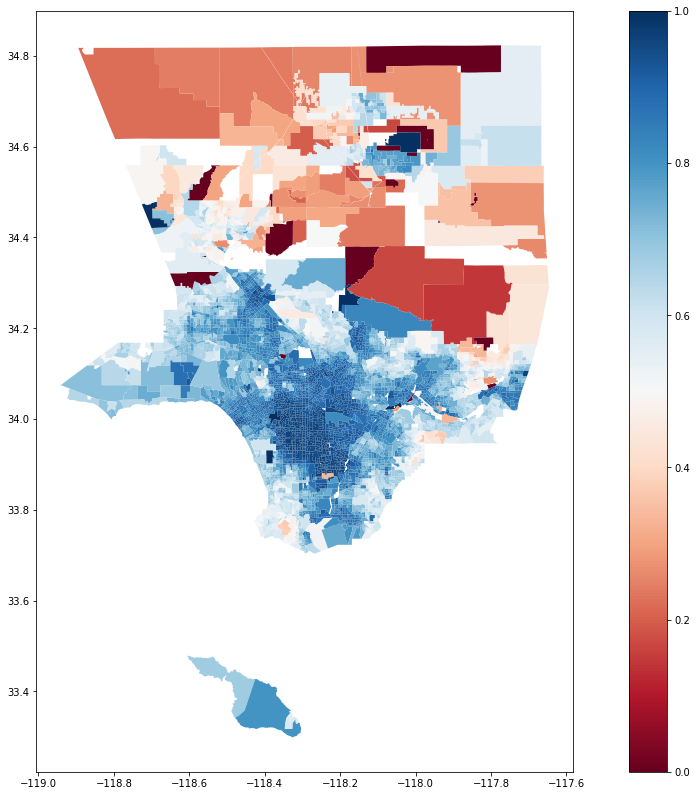

In [2]:
gdf.plot("per_clinton", legend=True, cmap='RdBu', figsize=(20,14))

Zadatak istraživanja je ispitivanje slučajeva u kojima jedna opština glasa izrazito drugačije od onih koje je okružuju (npr. ostrva crvenih glasača u moru plavih). Razumevanje ovih pojava nam daje dublji uvid u opšti obrazac ponašanja glasača na nivou svih okruga. U nekim okruzima sve opštine glasaju na sličan način, dok druge mogu sadržati zajednice koje glasaju drugačije od svojih suseda, što potencijalno signalizira prisustvo urbanih naselja, demografski različitih naselja, ili neregularnosti na glasanju.

## Postojeće metode za konstruisanje simplicijalnih kompleksa

<AxesSubplot:>

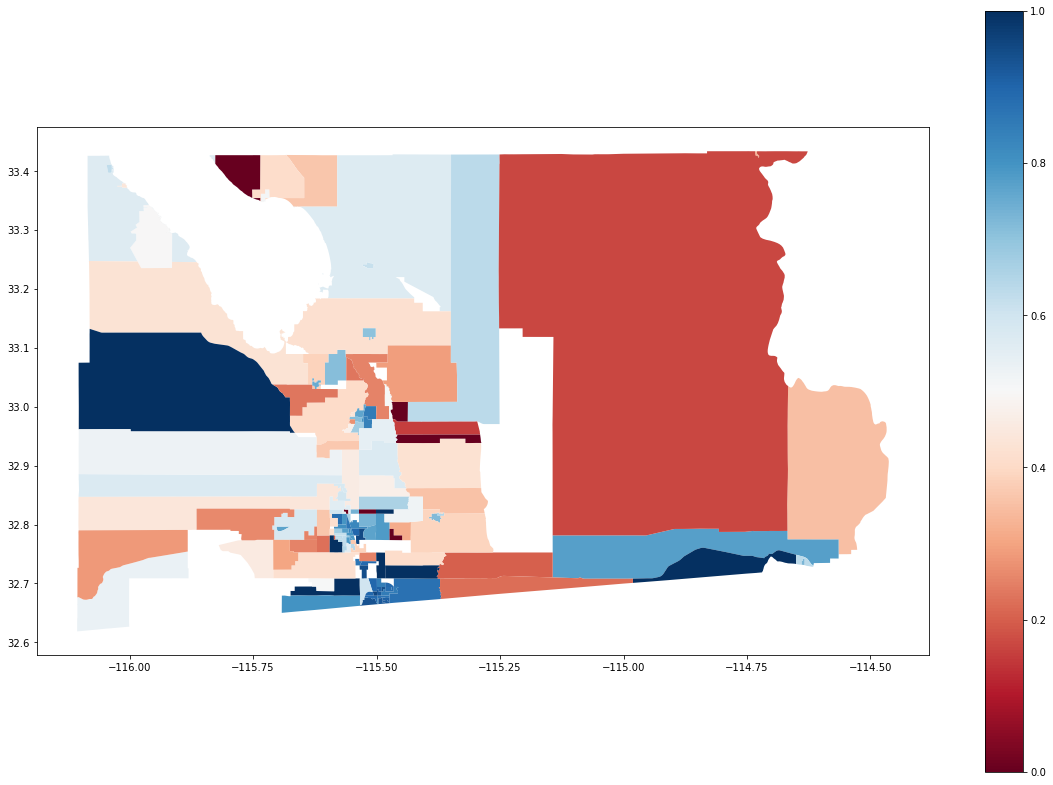

In [160]:
import gudhi
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

gdf = load_data('025-imperial')

gdf.plot("per_clinton", legend=True, cmap='RdBu', figsize=(20,14))

### VR Complex

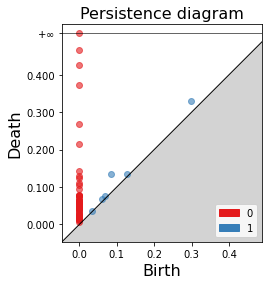

In [161]:
gdf = gdf[gdf['abs_clinton'] < gdf['abs_trump']]
points = [[x, y] for x, y in zip(gdf['centroid'].values.x, gdf['centroid'].values.y)]

rips_complex = gudhi.RipsComplex(points)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

diag = simplex_tree.persistence()
pers_file = 'rips.pers'
simplex_tree.write_persistence_diagram(pers_file)

ax = gudhi.plot_persistence_diagram(
    persistence_file=pers_file,
    legend=True)
ax.set_aspect("equal")

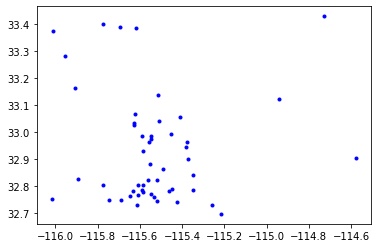

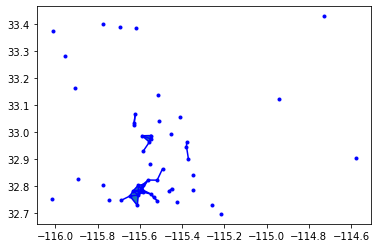

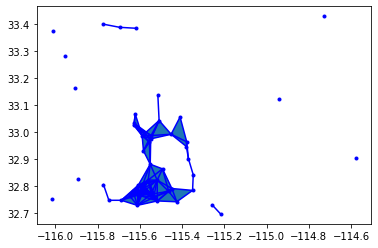

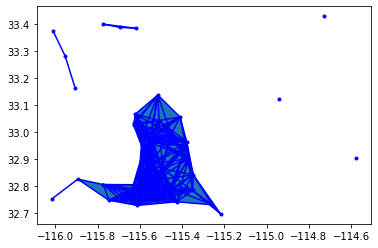

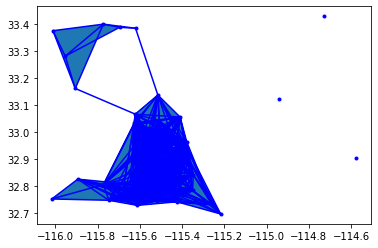

In [162]:
from utils import plot_simplices

plot_simplices(points, simplex_tree, 0.01)
plot_simplices(points, simplex_tree, 0.05)
plot_simplices(points, simplex_tree, 0.1)
plot_simplices(points, simplex_tree, 0.2)
plot_simplices(points, simplex_tree, 0.3)

Assumption 1: No 2 homology classes have the same birth time
	satisified: True

Assumption 2: No 2 edges have the same length. (Doesn't have to be satisfied.)
	satisified: True



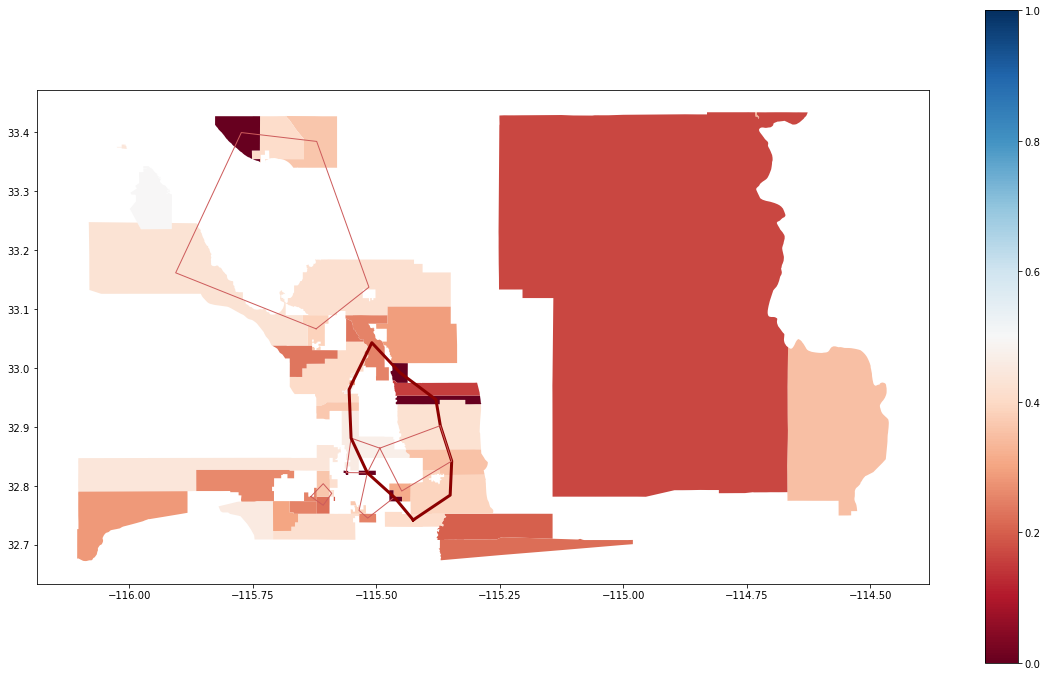

In [163]:
from utils import plot_loops, persistence_1D_with_loops

persistence = persistence_1D_with_loops(simplex_tree)
plot_loops(gdf, points, persistence)

### Alpha Complex

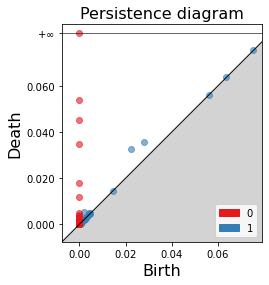

In [164]:
alpha_complex = gudhi.AlphaComplex(points)
simplex_tree = alpha_complex.create_simplex_tree()

diag = simplex_tree.persistence()

pers_file = 'alpha.pers'
simplex_tree.write_persistence_diagram(pers_file)

ax = gudhi.plot_persistence_diagram(
    persistence_file=pers_file,
    legend=True)
ax.set_aspect("equal")

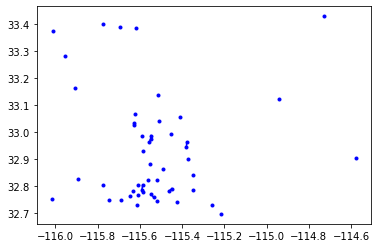

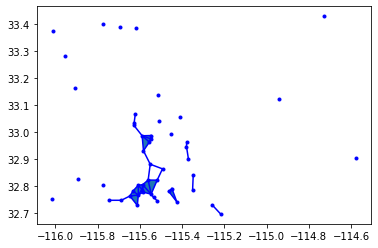

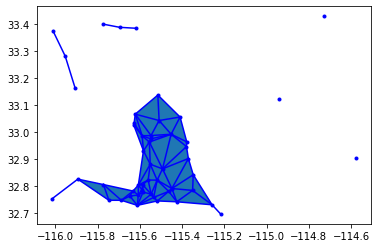

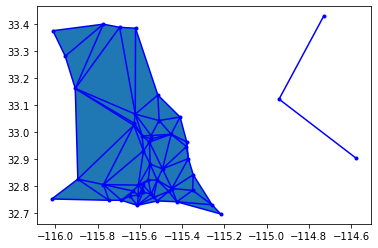

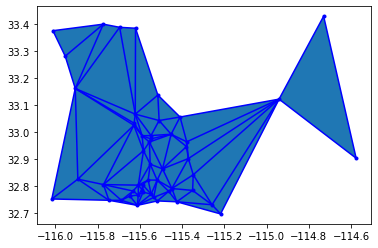

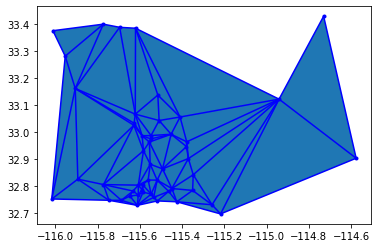

In [165]:
plot_simplices(points, simplex_tree, 0.0001)
plot_simplices(points, simplex_tree, 0.001)
plot_simplices(points, simplex_tree, 0.01)
plot_simplices(points, simplex_tree, 0.05)
plot_simplices(points, simplex_tree, 0.1)
plot_simplices(points, simplex_tree, 0.2)

Algorithm for constructing loops taken from the paper:
Topological data analysis reveals principles of chromosome structure throughout cellular differentiation
https://www.biorxiv.org/content/10.1101/540716v1.full.pdf

Assumption 1: No 2 homology classes have the same birth time
	satisified: True

Assumption 2: No 2 edges have the same length. (Doesn't have to be satisfied.)
	satisified: True



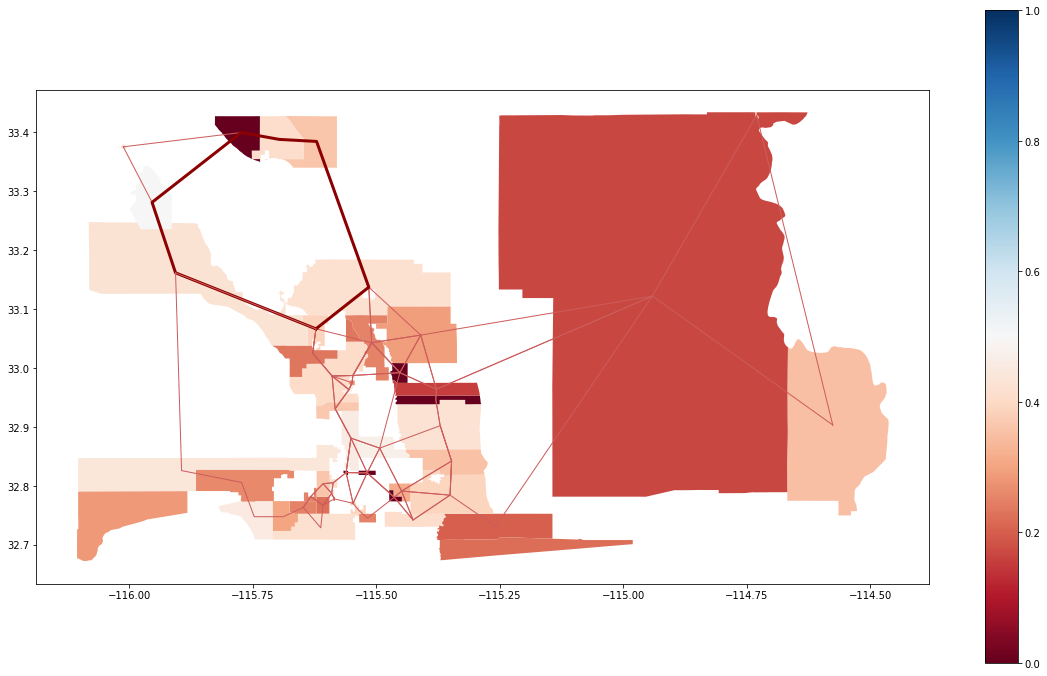

In [10]:
persistence = persistence_1D_with_loops(simplex_tree)
plot_loops(gdf, points, persistence)

## Adjacency complex

In [99]:
gdf = load_data('025-imperial')

gdf = gdf[gdf['abs_clinton'] < gdf['abs_trump']]
points = [[x, y] for x, y in zip(gdf['centroid'].values.x, gdf['centroid'].values.y)]

In [100]:
def delta(votes_clinton, votes_trump):
    sum_votes = votes_clinton + votes_trump
    if sum_votes == 0:
        return 0
    
    return abs(votes_clinton - votes_trump)/sum_votes

In [101]:
pct_id_to_vert = {}
vert_to_pct_id = [None] * len(gdf)
vert = 0
for index, row in gdf.iterrows():
    gdf.at[index, 'delta'] = delta(row['abs_clinton'], row['abs_trump'])
    pct_id_to_vert[index] = vert
    vert_to_pct_id[vert] = index
    vert += 1

In [102]:
import numpy as np
from utils import get_adjacency_simplex_tree

simplex_tree = get_adjacency_simplex_tree(gdf, pct_id_to_vert)

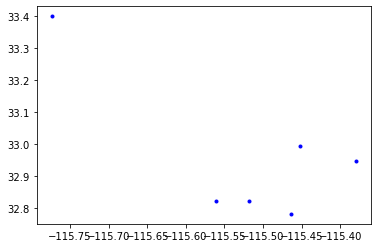

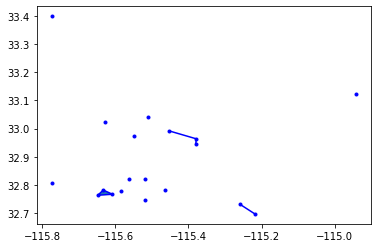

In [103]:
plot_simplices(points, simplex_tree, 0.06)
plot_simplices(points, simplex_tree, 0.6)
# plot_simplices(points, simplex_tree, 0.9)
# plot_simplices(points, simplex_tree, 1)

In [106]:
[x for x in simplex_tree.persistence() if x[0] == 1]

[(1, (0.95, inf)), (1, (0.9, inf))]

Assumption 1: No 2 homology classes have the same birth time
	satisified: True

Assumption 2: No 2 edges have the same length. (Doesn't have to be satisfied.)
	satisified: False



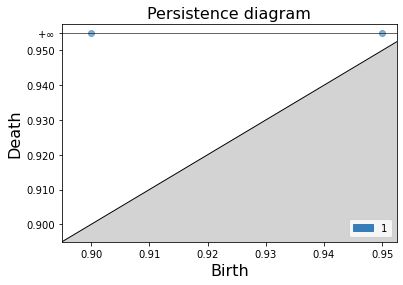

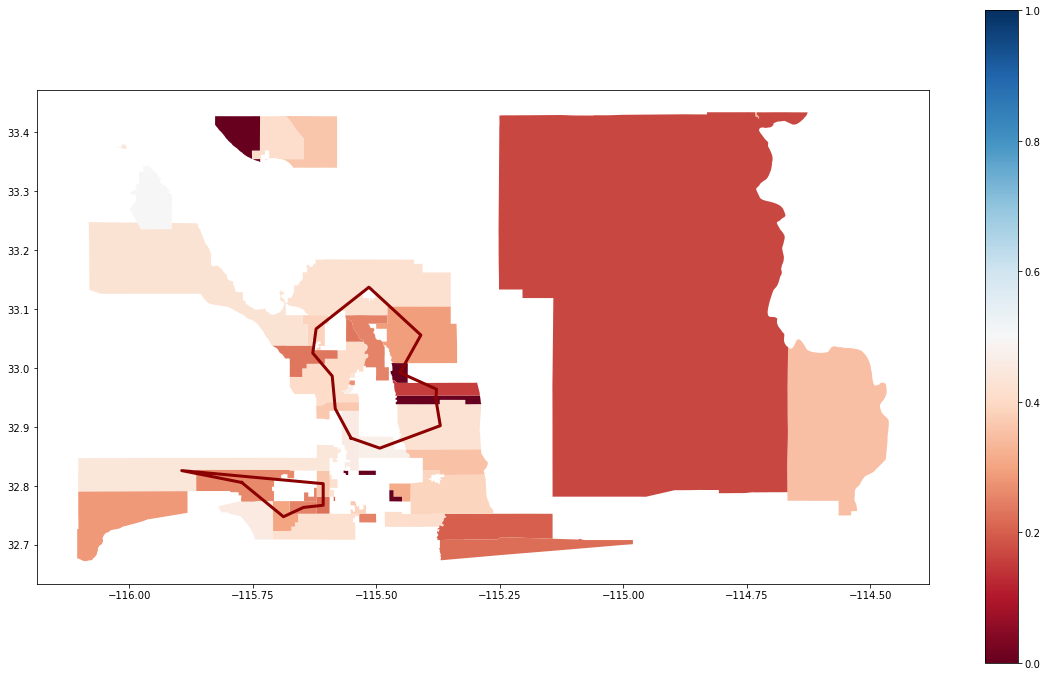

In [107]:
persistence = persistence_1D_with_loops(simplex_tree, adjacency_complex=True)

pers_file = 'adjacency.pers'
simplex_tree.write_persistence_diagram(pers_file)

ax = gudhi.plot_persistence_diagram(
    [x for x in simplex_tree.persistence() if x[0] == 1],
    legend=True)

plot_loops(gdf, points, persistence)

<AxesSubplot:>

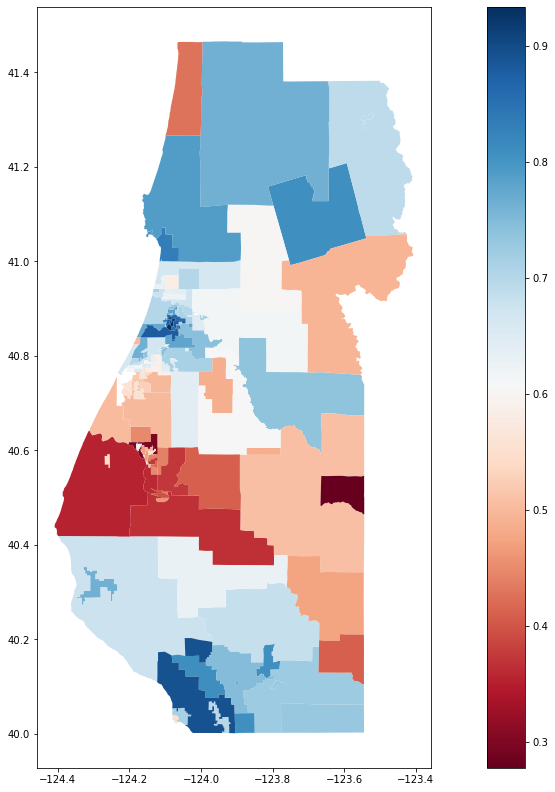

In [138]:
import gudhi
import matplotlib.pyplot as plt
from utils import load_data

gdf = load_data('023-humboldt')

gdf.plot("per_clinton", legend=True, cmap='RdBu', figsize=(20,14))

### VR Complex

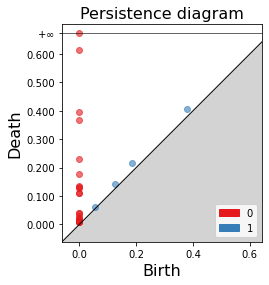

In [139]:
gdf = gdf[gdf['abs_clinton'] < gdf['abs_trump']]
points = [[x, y] for x, y in zip(gdf['centroid'].values.x, gdf['centroid'].values.y)]

rips_complex = gudhi.RipsComplex(points)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

diag = simplex_tree.persistence()
pers_file = 'rips.pers'
simplex_tree.write_persistence_diagram(pers_file)

ax = gudhi.plot_persistence_diagram(
    persistence_file=pers_file,
    legend=True)
ax.set_aspect("equal")

Assumption 1: No 2 homology classes have the same birth time
	satisified: True

Assumption 2: No 2 edges have the same length. (Doesn't have to be satisfied.)
	satisified: True



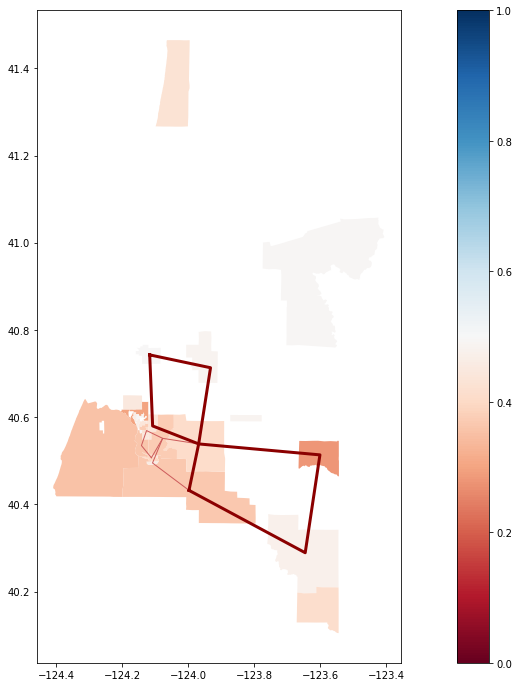

In [140]:
from utils import plot_loops, persistence_1D_with_loops

persistence = persistence_1D_with_loops(simplex_tree)
plot_loops(gdf, points, persistence)

### Alpha Complex

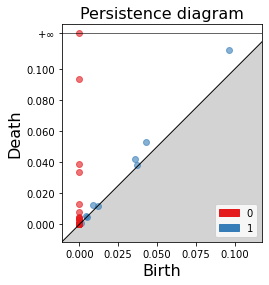

In [141]:
alpha_complex = gudhi.AlphaComplex(points)
simplex_tree = alpha_complex.create_simplex_tree()

diag = simplex_tree.persistence()

pers_file = 'alpha.pers'
simplex_tree.write_persistence_diagram(pers_file)

ax = gudhi.plot_persistence_diagram(
    persistence_file=pers_file,
    legend=True)
ax.set_aspect("equal")

Assumption 1: No 2 homology classes have the same birth time
	satisified: True

Assumption 2: No 2 edges have the same length. (Doesn't have to be satisfied.)
	satisified: True



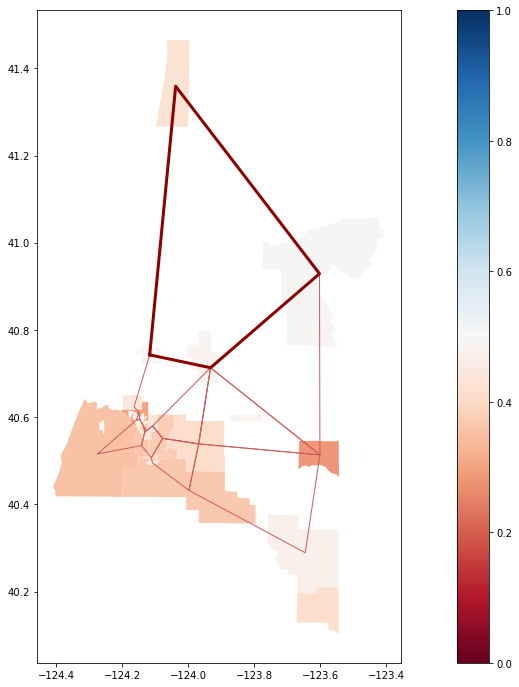

In [142]:
persistence = persistence_1D_with_loops(simplex_tree)
plot_loops(gdf, points, persistence)

## Adjacency complex

In [143]:
import gudhi
import matplotlib.pyplot as plt
from utils import load_data

# gdf = load_data('007-butte')
# gdf = load_data('017-el-dorado')
# gdf = load_data('023-humboldt')
gdf = load_data('023-humboldt')

gdf = gdf[gdf['abs_clinton'] < gdf['abs_trump']]
points = [[x, y] for x, y in zip(gdf['centroid'].values.x, gdf['centroid'].values.y)]

In [144]:
def delta(votes_clinton, votes_trump):
    sum_votes = votes_clinton + votes_trump
    if sum_votes == 0:
        return 0
    
    return abs(votes_clinton - votes_trump)/sum_votes

In [145]:
import warnings
warnings.filterwarnings("ignore")

pct_id_to_vert = {}
vert_to_pct_id = [None] * len(gdf)
vert = 0
for index, row in gdf.iterrows():
    gdf.at[index, 'delta'] = delta(row['abs_clinton'], row['abs_trump'])
    pct_id_to_vert[index] = vert
    vert_to_pct_id[vert] = index
    vert += 1

In [146]:
import numpy as np
from utils import get_adjacency_simplex_tree

simplex_tree = get_adjacency_simplex_tree(gdf, pct_id_to_vert)

Assumption 1: No 2 homology classes have the same birth time
	satisified: True

Assumption 2: No 2 edges have the same length. (Doesn't have to be satisfied.)
	satisified: False



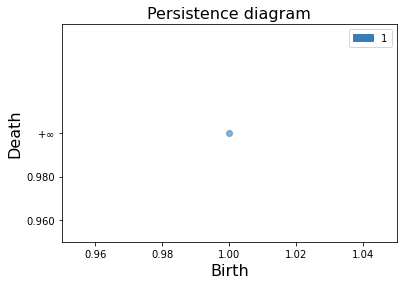

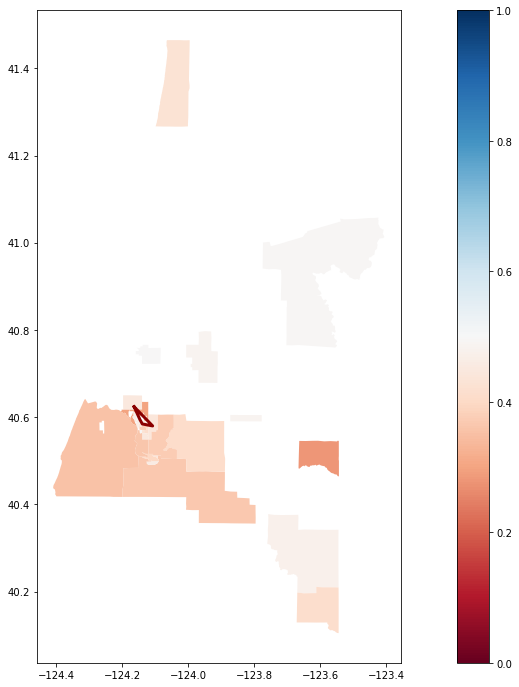

In [148]:
from utils import plot_simplices
from utils import plot_loops, persistence_1D_with_loops
persistence = persistence_1D_with_loops(simplex_tree, adjacency_complex=True)

pers_file = 'adjacency.pers'
simplex_tree.write_persistence_diagram(pers_file)

ax = gudhi.plot_persistence_diagram(
    [x for x in simplex_tree.persistence() if x[0] == 1],
    legend=True)

plot_loops(gdf, points, persistence)

<AxesSubplot:>

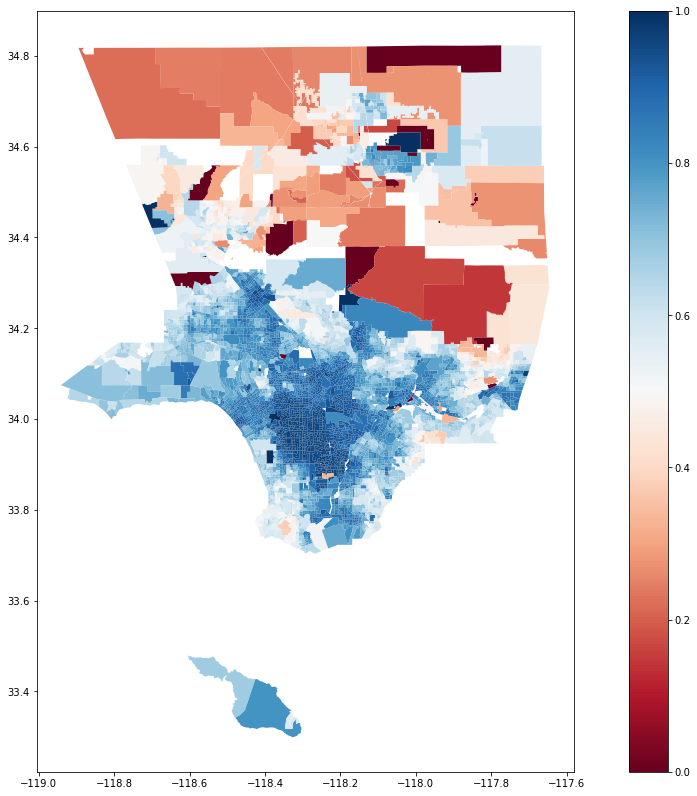

In [149]:
import gudhi
import matplotlib.pyplot as plt
from utils import load_data

gdf = load_data('037-los-angeles')

gdf.plot("per_clinton", legend=True, cmap='RdBu', figsize=(20,14))

### VR Complex

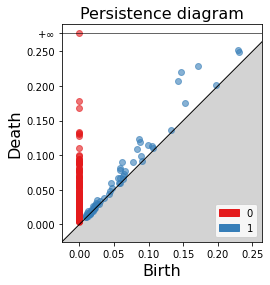

In [150]:
gdf = gdf[gdf['abs_clinton'] < gdf['abs_trump']]
points = [[x, y] for x, y in zip(gdf['centroid'].values.x, gdf['centroid'].values.y)]

rips_complex = gudhi.RipsComplex(points)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

diag = simplex_tree.persistence()
pers_file = 'rips.pers'
simplex_tree.write_persistence_diagram(pers_file)

ax = gudhi.plot_persistence_diagram(
    persistence_file=pers_file,
    legend=True)
ax.set_aspect("equal")

Assumption 1: No 2 homology classes have the same birth time
	satisified: True

Assumption 2: No 2 edges have the same length. (Doesn't have to be satisfied.)
	satisified: True



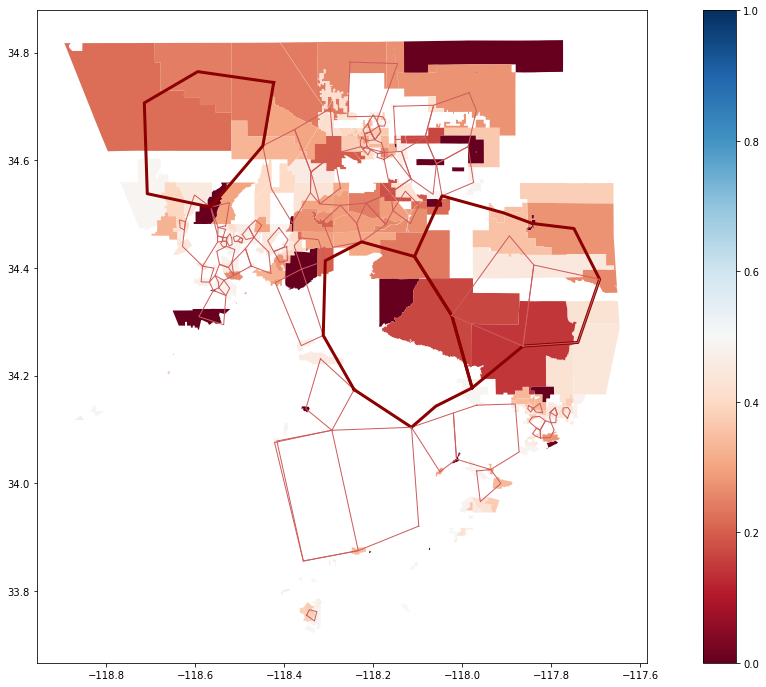

In [151]:
from utils import plot_loops, persistence_1D_with_loops

persistence = persistence_1D_with_loops(simplex_tree)
plot_loops(gdf, points, persistence)

### Alpha Complex

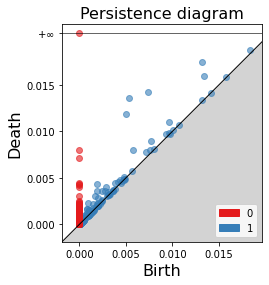

In [152]:
alpha_complex = gudhi.AlphaComplex(points)
simplex_tree = alpha_complex.create_simplex_tree()

diag = simplex_tree.persistence()

pers_file = 'alpha.pers'
simplex_tree.write_persistence_diagram(pers_file)

ax = gudhi.plot_persistence_diagram(
    persistence_file=pers_file,
    legend=True)
ax.set_aspect("equal")

Assumption 1: No 2 homology classes have the same birth time
	satisified: True

Assumption 2: No 2 edges have the same length. (Doesn't have to be satisfied.)
	satisified: True



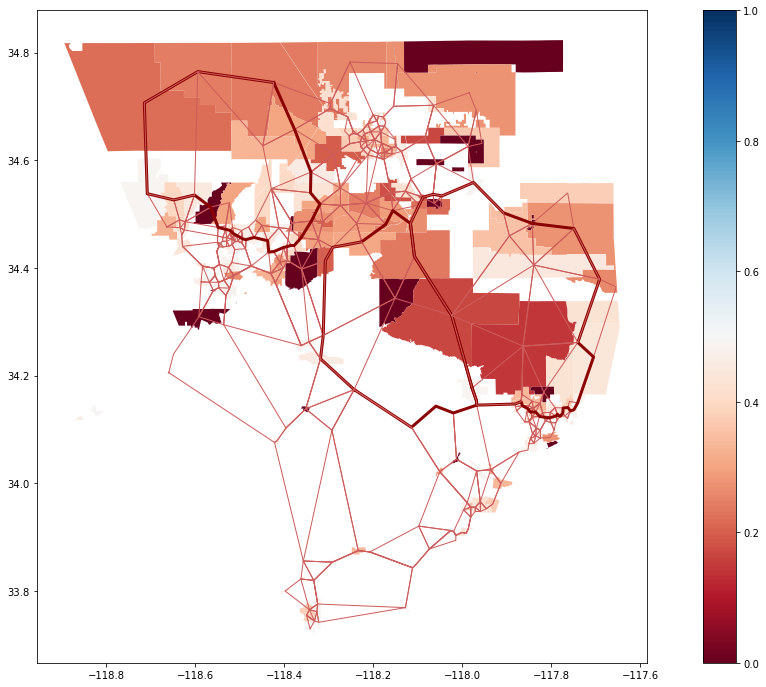

In [153]:
persistence = persistence_1D_with_loops(simplex_tree)
plot_loops(gdf, points, persistence)

## Adjacency complex

In [154]:
import gudhi
import matplotlib.pyplot as plt
from utils import load_data

gdf = load_data('037-los-angeles')

gdf = gdf[gdf['abs_clinton'] < gdf['abs_trump']]
points = [[x, y] for x, y in zip(gdf['centroid'].values.x, gdf['centroid'].values.y)]

In [155]:
def delta(votes_clinton, votes_trump):
    sum_votes = votes_clinton + votes_trump
    if sum_votes == 0:
        return 0
    
    return abs(votes_clinton - votes_trump)/sum_votes

In [156]:
import warnings
warnings.filterwarnings("ignore")

pct_id_to_vert = {}
vert_to_pct_id = [None] * len(gdf)
vert = 0
for index, row in gdf.iterrows():
    gdf.at[index, 'delta'] = delta(row['abs_clinton'], row['abs_trump'])
    pct_id_to_vert[index] = vert
    vert_to_pct_id[vert] = index
    vert += 1

In [157]:
import numpy as np
from utils import get_adjacency_simplex_tree

simplex_tree = get_adjacency_simplex_tree(gdf, pct_id_to_vert)

Assumption 1: No 2 homology classes have the same birth time
	satisified: False

Assumption 2: No 2 edges have the same length. (Doesn't have to be satisfied.)
	satisified: False



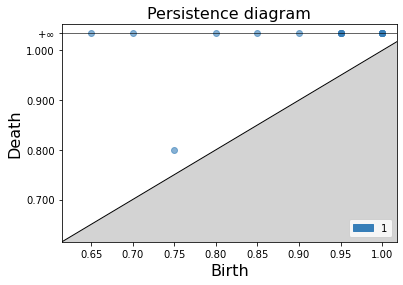

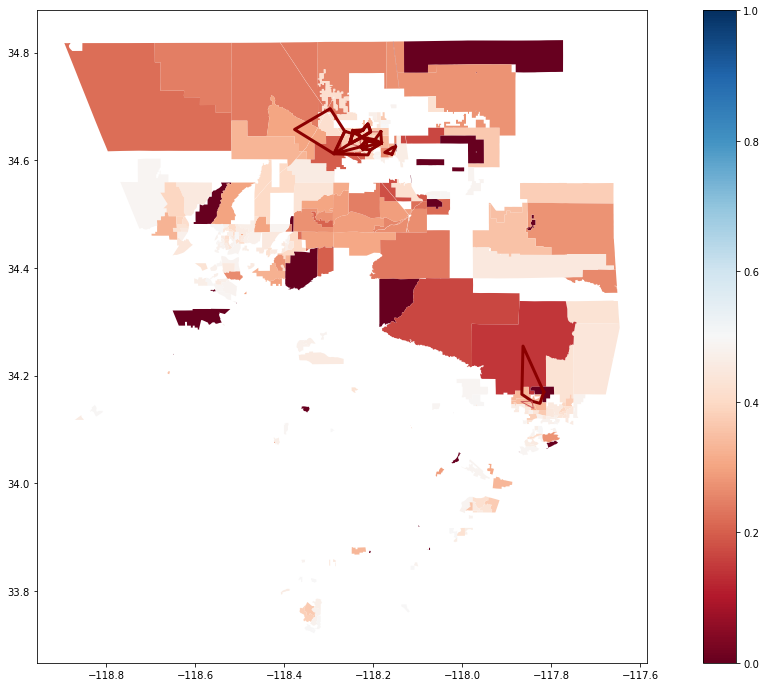

In [159]:
persistence = persistence_1D_with_loops(simplex_tree, adjacency_complex=True)

pers_file = 'adjacency.pers'
simplex_tree.write_persistence_diagram(pers_file)

ax = gudhi.plot_persistence_diagram(
    [x for x in simplex_tree.persistence() if x[0] == 1],
    legend=True)

plot_loops(gdf, points, persistence)